In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Função auxiliar para exibir imagens no notebook
def show(img, title='', cmap=None):
    plt.figure(figsize=(6,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

model = YOLO('best.pt')


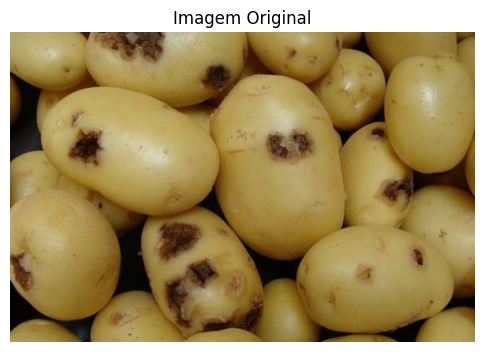


image 1/1 c:\Users\andre\Desktop\Visao\contagem-defeitos-batatas\sarna-comum-batata.jpg: 448x640 (no detections), 41.1ms
Speed: 1.2ms preprocess, 41.1ms inference, 0.3ms postprocess per image at shape (1, 3, 448, 640)


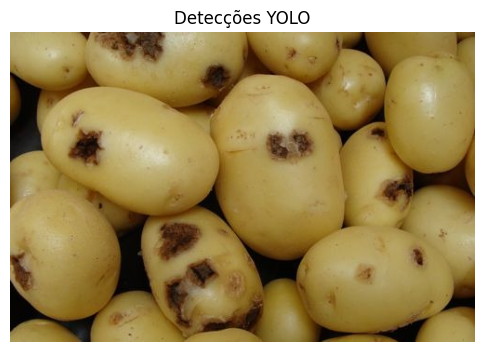

Detectou 0 objeto(s)


In [ ]:
# img_path = 'sarna-comum-batata.jpg'
# img_path = 'batata_ruim.jpeg'

img_path = 'sarna-comum-batata.jpg'

img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise FileNotFoundError(f"Imagem não encontrada: {img_path}")

show(img_bgr, "Imagem Original")
results = model(img_path)

# Mostrar imagem com detecções
annotated = results[0].plot()
show(annotated, "Detecções YOLO")

# Imprimir detalhes
for r in results:
    print(f"Detectou {len(r.boxes)} objeto(s)")
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        print(f"  - Classe: {r.names[cls]}, Confiança: {conf:.2f}")


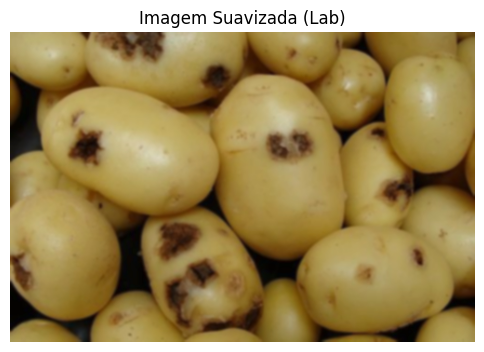

In [ ]:
# pre processamento

img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

# Suavizar para reduzir ruído
blur = cv2.GaussianBlur(img_lab, (5,5), 0)

show(cv2.cvtColor(blur, cv2.COLOR_LAB2BGR), "Imagem Suavizada (Lab)")


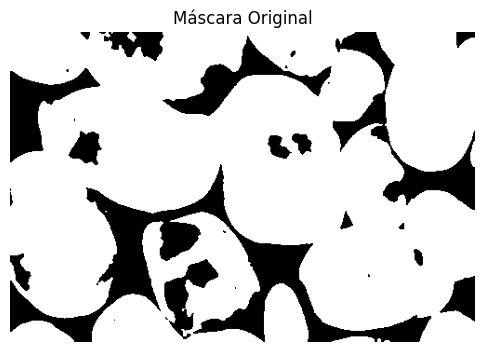

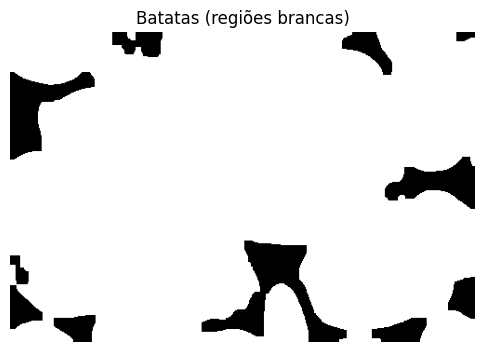

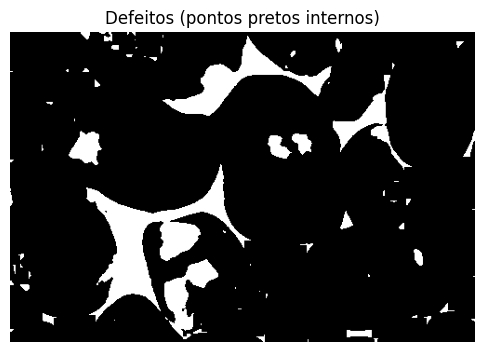

In [ ]:
#segmentacao 

L, A, B = cv2.split(blur)

_, mask = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

contours, hierarchy = cv2.findContours(mask_clean, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = mask_clean.copy()
for i in range(len(contours)):
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(mask_filled, [contours[i]], -1, 255, -1)

mask_defects = cv2.bitwise_not(mask)
mask_defects = cv2.bitwise_and(mask_defects, mask_filled)

kernel_small = np.ones((1,1), np.uint8)
mask_defects = cv2.morphologyEx(mask_defects, cv2.MORPH_OPEN, kernel_small)

show(mask, 'Máscara Original')
show(mask_filled, 'Batatas (regiões brancas)')
show(mask_defects, 'Defeitos (pontos pretos internos)')

mask = mask_filled


In [ ]:
# media e covarianca da regiao saudavel

pixels = blur[mask == 255].reshape(-1, 3)

mean = np.mean(pixels, axis=0)
cov = np.cov(pixels, rowvar=False)
inv_cov = np.linalg.inv(cov)

print("Média (Lab):", mean)
print("Covariância:")
print(cov)


Média (Lab): [140.68607142 129.81882369 164.34598831]
Covariância:
[[1402.88534726 -127.51454687  120.27930769]
 [-127.51454687   19.42923676   -2.87056649]
 [ 120.27930769   -2.87056649   66.79113153]]


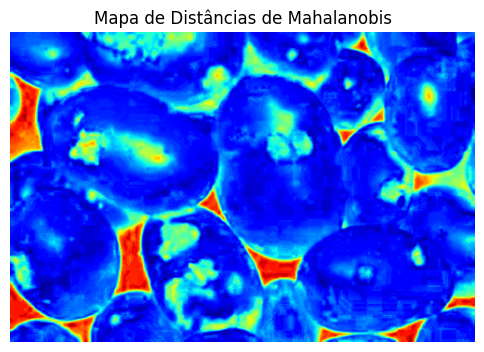

In [ ]:
# calculo de mahalanobis

h, w, c = blur.shape
diff = blur.reshape(-1, 3) - mean
mdist = np.sqrt(np.einsum('ij,jk,ik->i', diff, inv_cov, diff))
mdist_img = mdist.reshape(h, w)

# Normalizar para 0-255
mdist_norm = cv2.normalize(mdist_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
show(mdist_norm, "Mapa de Distâncias de Mahalanobis", cmap='jet')


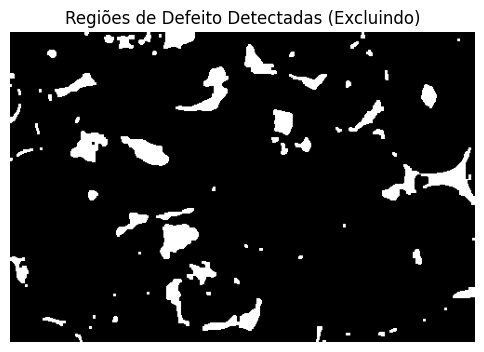

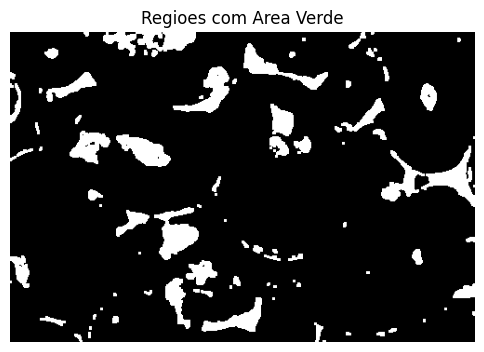

In [ ]:
# destacar defeitos

_, exclude_mask = cv2.threshold(mdist_norm, 180, 255, cv2.THRESH_BINARY)
_, defect_mask = cv2.threshold(mdist_norm, 100, 255, cv2.THRESH_BINARY)

defect_mask = cv2.bitwise_and(defect_mask, cv2.bitwise_not(exclude_mask))

# Limpeza morfológica
kernel_defect = np.ones((3,3), np.uint8)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, kernel_defect)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_CLOSE, kernel_defect)

# testando pegando apenas as partes verdes

lower = 90
upper = 180

green_mask = cv2.inRange(mdist_norm, lower, upper)
green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel_defect)

show(defect_mask, "Regiões de Defeito Detectadas (Excluindo)")
show(green_mask, "Regioes com Area Verde")

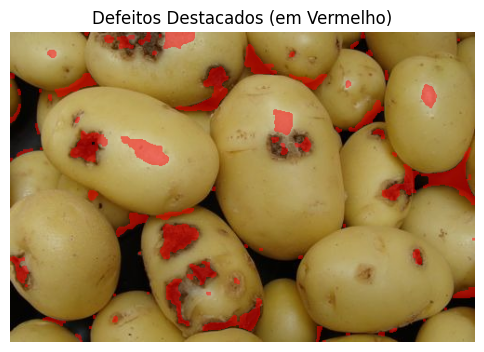

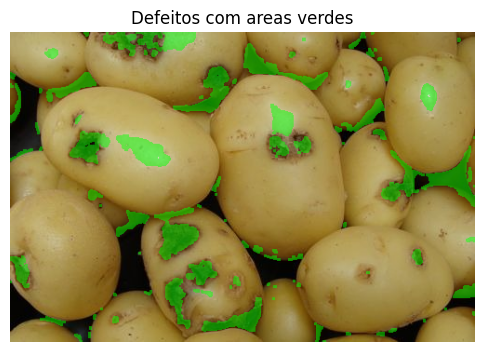

In [ ]:
# sobreposicao na imagem original

overlay = img_bgr.copy()
overlay[defect_mask == 255] = [0, 0, 255]  # pinta em vermelho

overlay_green = img_bgr.copy()
overlay_green[green_mask == 255] = [0, 255, 0] # pinta em verde

alpha = 0.5
result = cv2.addWeighted(img_bgr, 1 - alpha, overlay, alpha, 0)
result_green = cv2.addWeighted(img_bgr, 1 - alpha, overlay_green, alpha, 0)

show(result, "Defeitos Destacados (em Vermelho)")
show(result_green, "Defeitos com areas verdes")


In [ ]:
defect_area = np.sum(defect_mask == 255)
potato_area = np.sum(mask == 255)
percent_defect = (defect_area / potato_area) * 100

print(f"Porcentagem da área com defeito: {percent_defect:.2f}%")


Porcentagem da área com defeito: 8.77%


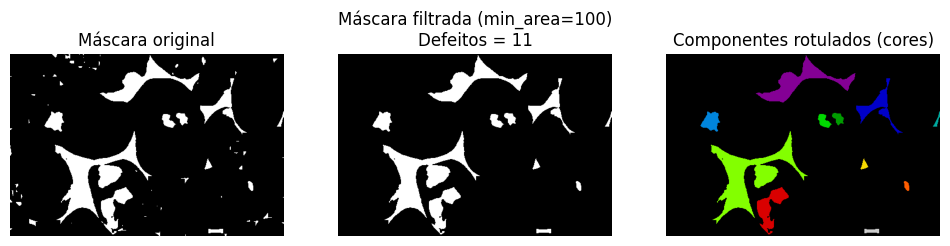

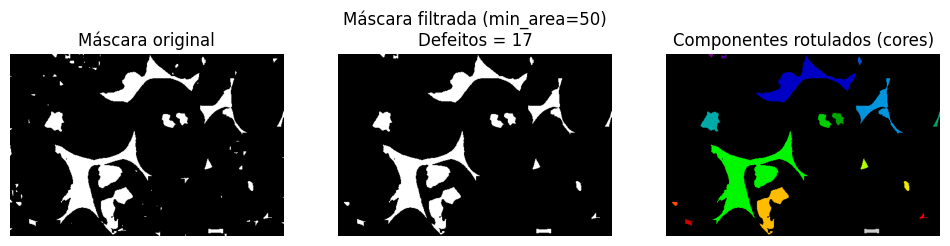

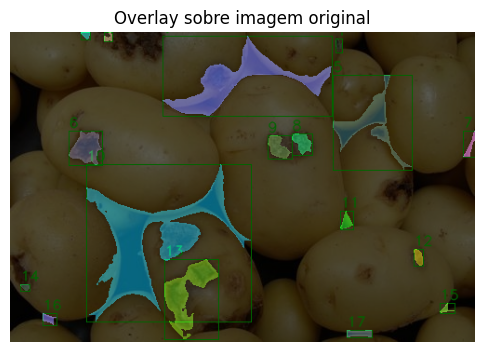

17


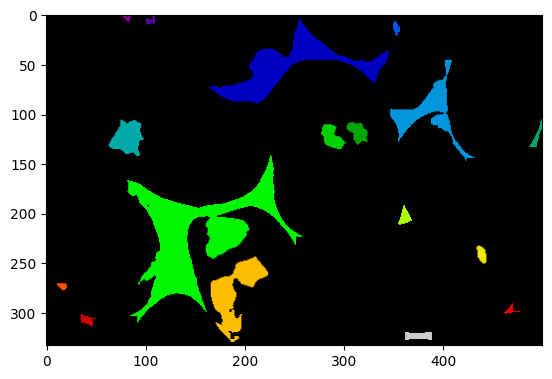

In [ ]:
# === Função para contar e analisar defeitos (Connected Components) ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def count_defects(mask,
                  min_area=50,
                  connectivity=8,
                  visualize=True,
                  return_stats=False,
                  save_dir=None,
                  overlay_image=None,
                  alpha=0.6):
    """
    Conta componentes conectados em uma máscara binária (defeitos).
    
    Args:
        mask: array 2D (bool, 0/255 ou 0/1) - máscara binária (defeito = True/1/255).
        min_area: int - área mínima em pixels para considerar um componente válido.
        connectivity: 4 or 8 - conectividade para labeling.
        visualize: bool - se True, plota a imagem rotulada e a máscara filtrada.
        return_stats: bool - se True, retorna (num_defeitos, labels_filtered, stats_filtered, centroids_filtered, overlay)
        save_dir: str or None - se informado, salva imagens dos defeitos no diretório (um arquivo por defeito).
        overlay_image: BGR image (altura x largura x 3) - se fornecida, cria overlay com contornos/caixas e números.
        alpha: float (0..1) - transparência do overlay se overlay_image for fornecida.

    Retorna:
        Se return_stats==False: num_defeitos (int)
        Se return_stats==True: dict com chaves:
            num_defects, labels_filtered, stats_filtered, centroids_filtered, mask_filtered, overlay (ou None)
    """
    # --- preparar a máscara binária ---
    if mask.dtype == np.bool_:
        mask_bin = (mask.astype(np.uint8)) * 255
    else:
        mask_bin = mask.copy()
        # valores entre 0-1 -> escalar
        if mask_bin.max() <= 1:
            mask_bin = (mask_bin * 255).astype(np.uint8)
        else:
            mask_bin = mask_bin.astype(np.uint8)
    # garantir binário
    _, mask_bin = cv2.threshold(mask_bin, 1, 255, cv2.THRESH_BINARY)

    # --- connected components with stats ---
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_bin, connectivity=connectivity)

    # stats: linha por rótulo (inclui 0=fundo): [x, y, width, height, area]
    # filtrar componentes por área (ignorar rótulo 0 - fundo)
    valid_indices = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            valid_indices.append(i)

    num_defects = len(valid_indices)

    # construir máscara filtrada e rotulada com novos rótulos 1..N
    h, w = mask_bin.shape[:2]
    labels_filtered = np.zeros((h, w), dtype=np.int32)
    stats_filtered = []
    centroids_filtered = []

    for new_label, old_label in enumerate(valid_indices, start=1):
        labels_filtered[labels == old_label] = new_label
        stats_filtered.append(stats[old_label].tolist())
        centroids_filtered.append(centroids[old_label].tolist())

    stats_filtered = np.array(stats_filtered) if len(stats_filtered) > 0 else np.zeros((0,5), dtype=np.int32)
    centroids_filtered = np.array(centroids_filtered) if len(centroids_filtered) > 0 else np.zeros((0,2))

    mask_filtered = (labels_filtered > 0).astype(np.uint8) * 255

    # --- opcional: salvar cada defeito em arquivo ---
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        for lab in range(1, labels_filtered.max() + 1):
            comp_mask = (labels_filtered == lab).astype(np.uint8) * 255
            x, y, w_box, h_box, area = stats_filtered[lab - 1]
            # recortar da máscara original e também (se houver) da overlay_image
            crop_mask = comp_mask[y:y+h_box, x:x+w_box]
            save_path_mask = os.path.join(save_dir, f"defeito_{lab:03d}_mask.png")
            cv2.imwrite(save_path_mask, crop_mask)
            if overlay_image is not None:
                crop_img = overlay_image[y:y+h_box, x:x+w_box]
                save_path_img = os.path.join(save_dir, f"defeito_{lab:03d}_img.png")
                cv2.imwrite(save_path_img, crop_img)

    # --- opcional: overlay sobre imagem original ---
    overlay = None
    if overlay_image is not None:
        # garantir BGR uint8
        img = overlay_image.copy()
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

        # criar uma imagem colorida para as máscaras rotuladas (cada defeito com cor distinta)
        colored = np.zeros_like(img)
        rng = np.random.RandomState(12345)
        colors = [(int(c[0]), int(c[1]), int(c[2])) for c in rng.randint(0, 255, size=(max(1, labels_filtered.max()), 3))]
        for lab in range(1, labels_filtered.max() + 1):
            mask_lab = (labels_filtered == lab)
            colored[mask_lab] = colors[lab - 1]

            # desenhar bounding box e número
            x, y, w_box, h_box, area = stats_filtered[lab - 1]
            cv2.rectangle(img, (x, y), (x + w_box, y + h_box), (0, 255, 0), 1)
            cv2.putText(img, str(lab), (x, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

        # combinar original + colored
        colored_blend = cv2.addWeighted(img, 1 - alpha, colored, alpha, 0)
        overlay = colored_blend

    # --- visualização ---
    if visualize:
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.title("Máscara original")
        plt.axis('off')
        plt.imshow(mask_bin, cmap='gray')

        plt.subplot(1,3,2)
        plt.title(f"Máscara filtrada (min_area={min_area})\nDefeitos = {num_defects}")
        plt.axis('off')
        plt.imshow(mask_filtered, cmap='gray')

        plt.subplot(1,3,3)
        plt.title("Componentes rotulados (cores)")
        plt.axis('off')
        # usar mapa de cores para labels_filtered: mostrar 0 como preto
        if labels_filtered.max() > 0:
            plt.imshow(labels_filtered, cmap='nipy_spectral')
        else:
            plt.imshow(labels_filtered, cmap='gray')
        plt.show()

        if overlay is not None:
            plt.figure(figsize=(6,6))
            plt.title("Overlay sobre imagem original")
            plt.axis('off')
            # overlay está em BGR -> converter para RGB para matplotlib
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.show()

    # --- retorno ---
    result = {
        'num_defects': num_defects,
        'labels_filtered': labels_filtered,
        'stats_filtered': stats_filtered,
        'centroids_filtered': centroids_filtered,
        'mask_filtered': mask_filtered,
        'overlay': overlay
    }

    if return_stats:
        return result
    else:
        return num_defects


# === Exemplo de uso ===
# Supondo que 'mask' é sua máscara (numpy array) produzida pelo YOLO:
num = count_defects(mask_defects, min_area=100, connectivity=8, visualize=True)
#
# Para obter estatísticas e overlay:
res = count_defects(mask_defects, min_area=50, return_stats=True, overlay_image=img_bgr)
print(res['num_defects'])
plt.imshow(res['labels_filtered'], cmap='nipy_spectral')
